# Fitting a transit model

In this notebook, we will fit a transit model to a synthetic transit data of KELT-11 b.

The notebook is heavily dependent on `exoplanet` documentation: https://gallery.exoplanet.codes/tutorials/transit/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from exotoolbox.utils import tdur
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import arviz as az
import corner
import pickle
import os

Let's first visualise the data,

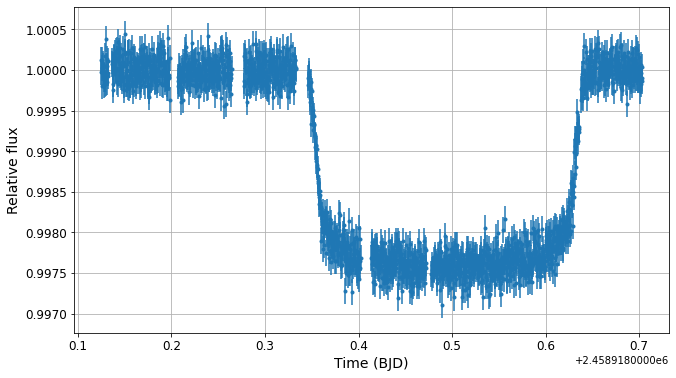

In [2]:
nsamp = 2000

p1 = '/'.join(os.getcwd().split('/')[:-1])
tim, fl, fle = np.loadtxt(p1 + '/Data/kelt-11-synthetic.dat', usecols=(0,1,2), unpack=True)

fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(tim, fl, yerr=fle, fmt='.')
axs.set_xlabel('Time (BJD)', fontsize=14)
axs.set_ylabel('Relative flux', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()

We will now fit a transit model to this dataset: the transit model will be provided by `exoplanet` package (I think they use `starry` in the backend for this). And on the top of this, we will use a `juliet` like normalisation model to normalise the data, i.e., 

$$y = \frac{\textnormal{Transit model}}{1 + mflux}$$

Here, $mflux$ is a normalisation constant (minus 1).

As usual, the likelihood function will assumed to be a normal distribution. And we will fit for an additional parameter for uncertainties on the flux: the assumption is that the uncertainties on the flux could be underestimated, so, we will add an additional term in quadrature to the flux uncertainties and fit for it. Let's do the thing:

In [3]:
# Planetary parameters (from various literature)
per, per_err = 4.7360990, np.sqrt((0.0000290**2) + (0.0000270**2))
tc, tc_err = 2458553.81381, 0.00033
ar, ar_err = 4.98, 0.05
bb, bb_err = 0.404, np.sqrt((0.013**2) + (0.018**2))
rprs, rprs_err = 0.0475, 0.0006
pi = np.pi
tduration = tdur(per=per, ar=ar, rprs=rprs, bb=bb)

cycle = round((tim[-1] - tc)/per)
t01 = np.random.normal(tc, tc_err, 100000) + (cycle * np.random.normal(per, per_err, 100000))
t0, t0_err = np.median(t01), np.std(t01)

with pm.Model() as model:
    # Priors on the model parameter
    # I will fix the period (since it is only one transit)
    tra_tim = pm.Normal('tc', mu=t0, sd=t0_err, testval=t0)
    
    rp_by_rs = pm.Uniform('rprs', lower=0., upper=1., testval=0.1)
    b = pm.Uniform('b', lower=0., upper=1., testval=0.1)
    t14 = pm.Uniform('t14', lower=0.2, upper=0.4, testval=0.3)
    
    u = xo.distributions.QuadLimbDark('u', testval=np.array([0.3, 0.2]))   # Kipping (2013) LDCs

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.SimpleTransitOrbit(period=per, duration=t14, t0=tra_tim, b=b, ror=rp_by_rs)

    # And the lightcurve
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(orbit=orbit, r=rp_by_rs, t=tim)
    
    # Instrumental parameters
    mflx = pm.Normal('mflx', mu=0., sd=0.05, testval=0.)                    # mflux
    log_sigw = pm.Uniform('logs', lower=-1, upper=4, testval=1)            # sigma_w
    sig_w = (10 ** log_sigw) * 1e-6
    inflated_var = pm.math.sqr(fle) + pm.math.sqr(sig_w)
    inflated_std = pm.math.sqrt(inflated_var)

    # And the final juliet-like model
    light_curve = (pm.math.sum(light_curves, axis=-1) + 1.) / (1 + mflx)

    # Let's also track the value of line for each iteration
    pm.Deterministic('lc', light_curves)
    # And the likelihood function,
    pm.Normal('obs', mu=light_curve, sd=inflated_std, observed=fl)
    # Optimizing it first
    map_soln = pmx.optimize(start=model.test_point)
    """map_soln = pmx.optimize(start=map_soln, vars=[tra_tim])
    map_soln = pmx.optimize(start=map_soln, vars=[rp_by_rs])
    map_soln = pmx.optimize(start=map_soln, vars=[b])
    map_soln = pmx.optimize(start=map_soln, vars=[t14])
    map_soln = pmx.optimize(start=map_soln, vars=[u])
    map_soln = pmx.optimize(start=map_soln, vars=[log_sigw, mflx])
    map_soln = pmx.optimize(start=map_soln, vars=[tra_tim])
    map_soln = pmx.optimize(start=map_soln, vars=[rp_by_rs])
    map_soln = pmx.optimize(start=map_soln, vars=[b])
    map_soln = pmx.optimize(start=map_soln, vars=[t14])
    map_soln = pmx.optimize(start=map_soln, vars=[u])
    map_soln = pmx.optimize(start=map_soln, vars=[log_sigw, mflx])
    map_soln = pmx.optimize(start=map_soln)"""

with model:
    trace = pmx.sample(
        tune=nsamp,
        draws=nsamp,
        start=map_soln,
        cores=8,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

pickle.dump(trace, open(p1 + '/Transit/Analysis/synth_pymc3.pkl','wb'))

optimizing logp for variables: [logs, mflx, u, t14, b, rprs, tc]


message: Desired error not necessarily achieved due to precision loss.
logp: -944434.0936548878 -> 11013.535638314246
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [logs, mflx, u, t14, b, rprs, tc]


/Users/japa6985/opt/anaconda3/envs/exo/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/japa6985/opt/anaconda3/envs/exo/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.


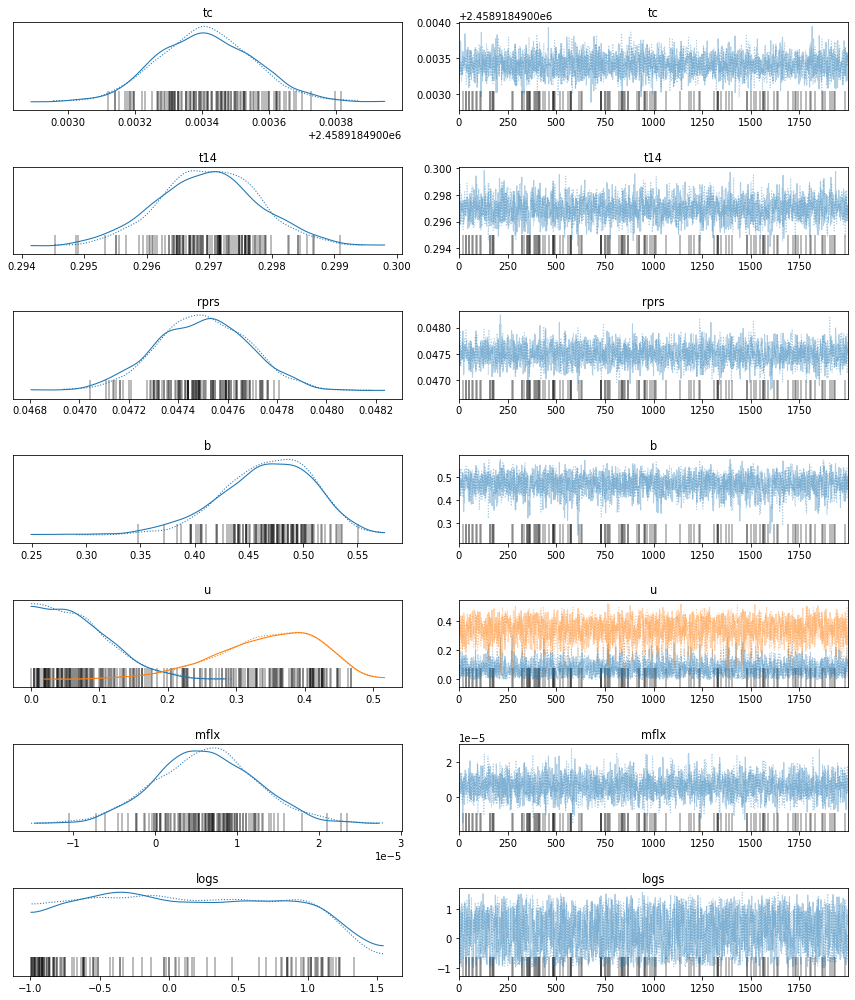

In [4]:
_ = az.plot_trace(trace, var_names=['tc', 't14', 'rprs', 'b', 'u', 'mflx', 'logs'])
plt.tight_layout()

In [5]:
az.summary(trace, var_names=['tc', 't14', 'rprs', 'b', 'u', 'mflx', 'logs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tc,2458918.493,0.000,2458918.493,2458918.494,0.000,0.000,2522.0,2218.0,1.0
t14,0.297,0.001,0.295,0.299,0.000,0.000,1923.0,1674.0,1.0
rprs,0.047,0.000,0.047,0.048,0.000,0.000,1791.0,1835.0,1.0
b,0.467,0.044,0.384,0.542,0.001,0.001,1595.0,1113.0,1.0
u[0],0.071,0.050,0.000,0.159,0.001,0.001,1316.0,972.0,1.0
u[1],0.345,0.077,0.199,0.473,0.002,0.001,1607.0,2580.0,1.0
mflx,0.000,0.000,-0.000,0.000,0.000,0.000,2613.0,2343.0,1.0
logs,0.171,0.670,-0.935,1.240,0.016,0.011,1544.0,1183.0,1.0


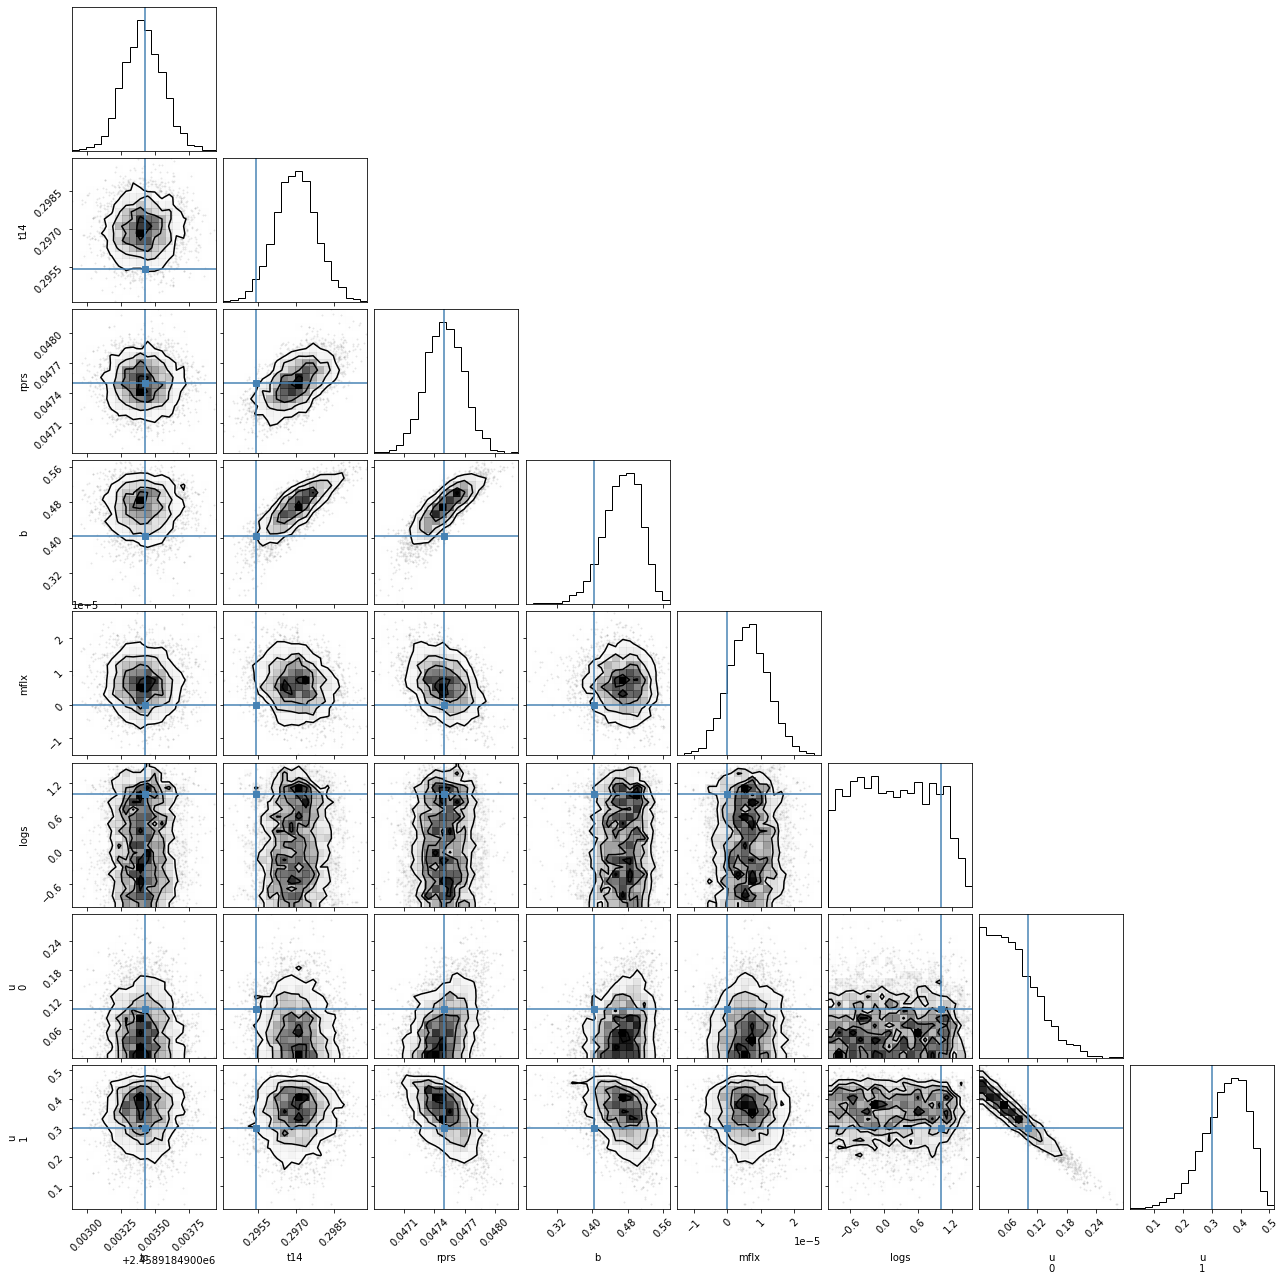

In [6]:
_ = corner.corner(trace, var_names=['tc', 't14', 'rprs', 'b', 'mflx', 'logs', 'u'],\
                  truths=np.array([t0, tduration, rprs, bb, 0., 1., 0.1, 0.3]),);

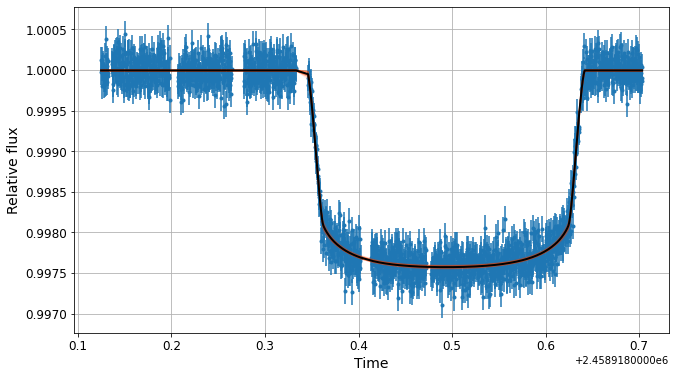

In [7]:
# Defining posteriors for each variable
mflx = np.array(trace.posterior['mflx']).flatten()
ls1 = np.array(trace.posterior['logs']).flatten()
ls2 = (10 ** ls1) * 1e-6
fl_deter = np.array(trace.posterior['lc']).reshape(2 * nsamp, len(tim))

fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(tim, fl, yerr=np.sqrt(fle**2 + np.nanmedian(ls2)**2), fmt='.')
axs.plot(tim, (np.nanmedian(fl_deter, axis=0) + 1.) / (1 + np.nanmedian(mflx)), 'k-', lw=2., zorder=20)
for i in range(50):
    axs.plot(tim, (fl_deter[np.random.choice(np.arange(fl_deter.shape[0])),:] + 1.) / (1 + np.random.choice(mflx)), c='orangered', lw=1., zorder=10, alpha=0.1)
axs.set_xlabel('Time', fontsize=14)
axs.set_ylabel('Relative flux', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()